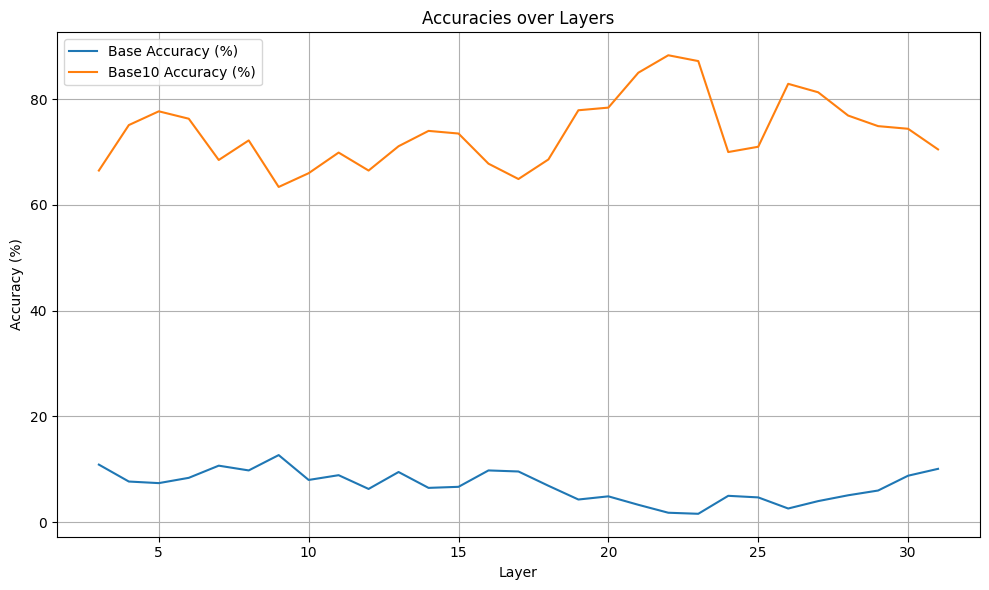

In [3]:
import json
import matplotlib.pyplot as plt

# Load the results
with open('../../../../outputs/arithmetic/intervention/base8/alpha_0.1/layer_result_full_dataset.json', 'r') as f:
    results = json.load(f)

# Extract layer numbers and accuracies
layers = []
base_accuracies = []
base10_accuracies = []
other_accuracies = []

for layer_str, data in results.items():
    layers.append(int(layer_str))
    base_accuracies.append(data['base_accuracy'] * 100)
    base10_accuracies.append(data['base10_accuracy'] * 100)
    other_accuracies.append(data['other_accuracy'] * 100)

# Sort by layer number
sorted_indices = sorted(range(len(layers)), key=lambda i: layers[i])
layers = [layers[i] for i in sorted_indices]
base_accuracies = [base_accuracies[i] for i in sorted_indices]
base10_accuracies = [base10_accuracies[i] for i in sorted_indices]
other_accuracies = [other_accuracies[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(layers, base_accuracies, label='Base Accuracy (%)')
plt.plot(layers, base10_accuracies, label='Base10 Accuracy (%)')
#plt.plot(layers, other_accuracies, label='Other Accuracy (%)')
plt.xlabel('Layer')
plt.ylabel('Accuracy (%)')
plt.title('Accuracies over Layers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Print the max accuracy and index in base array
print(f"Max accuracy: {max(base_accuracies)} at index {base_accuracies.index(max(base_accuracies))}")

# Print the top 5 accuracies and their indices
top_5_accuracies = sorted(base_accuracies, reverse=True)[:5]
top_5_indices = [base_accuracies.index(acc) + 3 for acc in top_5_accuracies]
print(f"Top 5 accuracies: {top_5_accuracies}")
print(f"Top 5 layers: {top_5_indices}")




Max accuracy: 12.7 at index 6
Top 5 accuracies: [12.7, 10.9, 10.7, 10.100000000000001, 9.8]
Top 5 layers: [9, 3, 7, 31, 8]


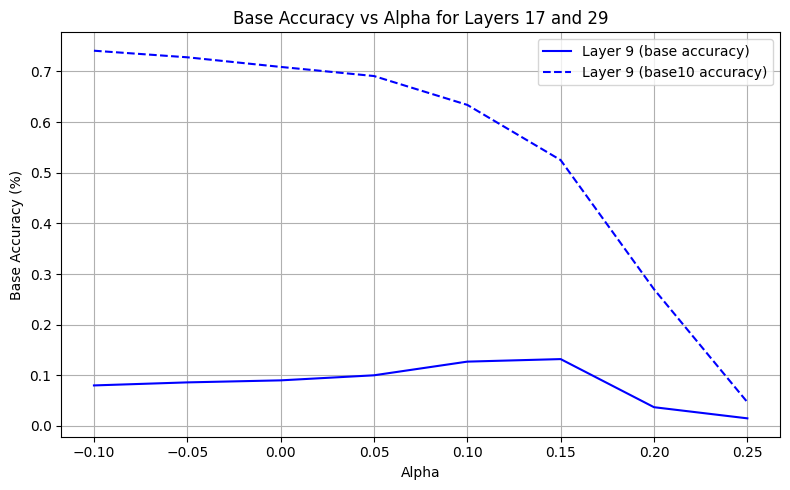

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
#TODO: Check no duplicates of the layers are in the file
# Settings
base_dir = '../../../../outputs/arithmetic/intervention/base8/'
alphas = [-0.1, -0.05, 0.0, 0.05, 0.1, 0.15, 0.20, 0.25]
layers_of_interest = [9]

# Prepare data storage
layer_base_accs = {layer: [] for layer in layers_of_interest}
layer_base10_accs = {layer: [] for layer in layers_of_interest}
layer_other_accs = {layer: [] for layer in layers_of_interest}

for alpha in alphas:
    alpha_str = f'alpha_{alpha:.2f}' if alpha % 0.1 else f'alpha_{alpha:.1f}'    
    # Adjust the formatting if your folder names are different!
    alpha_dir = os.path.join(base_dir, alpha_str)
    json_path = os.path.join(alpha_dir, 'layer_result_full_dataset.json')
    if alpha == 0.0:
        for layer in layers_of_interest:
            layer_base_accs[layer].append(0.09)
            layer_base10_accs[layer].append(0.709)
            layer_other_accs[layer].append(0.201)
    else:
        with open(json_path, 'r') as f:
            results = json.load(f)
        for layer in layers_of_interest:
            layer_str = str(layer)
            if layer_str in results:
                layer_base_accs[layer].append(results[layer_str]['base_accuracy'])
                layer_base10_accs[layer].append(results[layer_str]['base10_accuracy'])
                layer_other_accs[layer].append(results[layer_str]['other_accuracy'])
        

    # Plot
plt.figure(figsize=(8, 5))
colors = ['blue', 'red', 'green']
for i, layer in enumerate(layers_of_interest):
    plt.plot(alphas, layer_base_accs[layer], linestyle='-', label=f'Layer {layer} (base accuracy)', color=colors[i])
    plt.plot(alphas, layer_base10_accs[layer], linestyle='--', label=f'Layer {layer} (base10 accuracy)', color=colors[i])
    #plt.plot(alphas, layer_other_accs[layer], linestyle=':', label=f'Layer {layer} (other accuracy)', color=colors[i])
plt.xlabel('Alpha')
plt.ylabel('Base Accuracy (%)')
plt.title('Base Accuracy vs Alpha for Layers 17 and 29')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Code to evaluate LLM response

In [6]:
# Evaluate the model responses an accuracy
import hashlib
import re
import sys

import numpy as np

def get_label(expr, base):
    lhs, rhs = expr.split("+")
    lhs_base10 = int(lhs, base)
    rhs_base10 = int(rhs, base) 
    sum_base10 = lhs_base10 + rhs_base10
    return np.base_repr(sum_base10, base)

def unescape(str):
    placeholder = "<TMP>"
    assert placeholder not in str
    return str.replace("\\\\n", placeholder).replace("\\n", "\n").replace(placeholder, "\\n").replace("\\\\r", placeholder).replace("\\r", "\r").replace(placeholder, "\\r")


def parse_output(output):
    if len(output) == 0:
        return "FAILED"

    output_hash = hashlib.md5(output.encode("utf-8")).hexdigest()
    if output_hash in {"a7994fde4fba7d27500e6f03008abd7c"}:
        return "FAILED"

    output = output.replace(",", "").replace("С", "C")

    if (match := re.search("^[0-9A-Z]+$", output)) is not None:
        return output

    output = output.rstrip("\n$ `")
    if output.endswith("\n"):
        output = output[:-1]
    output = output.replace("\\text{", "")

    boxed_regex = r"boxed{(\\text{)?(result=)?([0-9A-Z]+(_{?[0-9]+}?)?\s*\+\s*[0-9A-Z]+(_{?[0-9]+}?)?\s*=\s*)?(0x)?([0-9A-Za-f \\.]+)(_ ?{?(base-)?([0-9]+|ten)}?)?}?(_{?([0-9]+|ten)}?)?}"
    get_result_from_boxed_regex = lambda match: match[-6].replace(" ", "").replace("\\", "")
    # match all \boxed{...} but also make sure there's only one match
    match = re.findall(boxed_regex, output)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    last_line = output.split("\n")[-1]
    match = re.findall(boxed_regex, last_line)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    last_line = output.rstrip(" .").split(".")[-1]
    match = re.findall(boxed_regex, last_line)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    if (match := re.search(r"\\boxed{[0-9A-Z]+}(_{?[0-9]+}?)?\s*\+\s*\\boxed{[0-9A-Z]+}(_{?[0-9]+}?)?\s*=\s*\\boxed{([0-9A-Z]+)}(_{?[0-9]+}?)?\.?$", last_line)) is not None:
        return match.groups()[-2]

    if (match := re.search(r"\\boxed{([0-9A-Z]+)_{?[0-9]+}?\s*=\s*[0-9A-Z]+_{?10}?}\$?\.?$", last_line)) is not None:
        return match.groups()[0]

    if (match := re.search(r"\$?[0-9A-Z]+(_{?[0-9]+}?)\s*\+\s*[0-9A-Z]+(_{?[0-9]+}?)\s*=\s*(0x)?([0-9A-Z]+)(_{?[0-9]+}?)\$?( in base-[0-9]+)?\.?$", output)) is not None:
        return match.groups()[-3]

    if (match := re.search(r"(=|is):?\s*\$?\\boxed{(0x)?([0-9A-Z]+)}\$? \(?in base-[0-9]+\)?,?( and| or| =) \$?\\boxed{(0x)?[0-9A-Z]+}\$? \(?in (base-10|decimal)\)?\.?$", output)) is not None:
        return match.groups()[2]
    if (match := re.search(r"(=|is):?\s*\$?\\boxed{(0x)?[0-9A-Z]+}\$? \(?in (base-10|decimal)\)?,?( and| or| =) \$?\\boxed{(0x)?([0-9A-Z]+)}\$? \(?in base-[0-9]+\)?\.?$", output)) is not None:
        return match.groups()[-1]
    # \boxed{207}_{10}$ which in base-11 is $\boxed{18A}$.
    if (match := re.search(r"\\boxed{[0-9A-Z]+}_\{10\}\$? which in base-[0-9]+ is \$?\\boxed{(0x)?([0-9A-Z]+)}\$?\.?$", output)) is not None:
        return match.groups()[-1]
    # 39 + 31 = 5A\boxed{}
    if (match := re.search(r"[0-9]+\s*\+\s*[0-9]+\s*=\s*([0-9A-Z]+)\\boxed\{\}\.?$", output)) is not None:
        return match.groups()[-1]

    # \boxed{result}\n62
    if (match := re.search(r"\\boxed{result}\s*(\n|=)?\s*([0-9A-Z+*^. ]+=\s*)?([0-9A-Z.]+)\$?\.?\**}?$", output)) is not None:
        return match.groups()[-1]

    # \boxed{result: 62}
    if (match := re.search(r"\\boxed{result: ([0-9A-Z]+)}$", output)) is not None:
        return match.groups()[0]

    match = re.findall(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+\s*=\s*(0x)?([0-9A-Z]+)", last_line)
    if len(match) == 1:
        return match[0][1]

    match_after_semicolon = r"\s+((\n|[ 0-9A-Z*^])+(\+(\n|[ 0-9A-Z*^])+)+(=|-+|_+)\s*)*([0-9A-Z]+)\s*(\(?(in )?base-[0-9]+\)?)?(, which [^,.]+)?(\s*\([^()]+\))?\.?$"
    if (match := re.search(r"\n([0-9A-Z]+)$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r" in base-[0-9]+ is (equal to )?\"?(0x)?([0-9A-Z]+)\"?( base-[0-9]+)?(, (or|since) [^.]+)?( \([^()]+\))?\.$", output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r" in base-[0-9]+: \$?([0-9A-Z]+)\$?\.$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r" the base-[0-9]+ sum: ([0-9A-Z]+)\.$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the result in base-[0-9]+ is ([0-9A-Z]+), which is equal to [0-9 *^+()]+\.$", output)) is not None:
        return match[1]
    if (match := re.search(r"the sum of [0-9A-Z]+ and [0-9A-Z]+ (in base-[0-9]+ )?(is|as):?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"the result of [0-9A-Z]+\s*\+\s*[0-9A-Z]+ (in base-[0-9]+ )?(is|as):?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+( in base-[0-9]+)?,? (which )?(equals|is equal to|as):? \$?([0-9A-Z]+)\$?(, written as [0-9A-Z]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"in base-10 is \$?[0-9]+\$?,? (which )?(equals|is equal to|as):? \$?([0-9A-Z]+)\$?(, written as [0-9A-Z]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+\s*=\s*([0-9A-Z]+)( in base-[0-9]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"we can simply write the result as ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"which can be written as ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"(which gives|giving) us the( base-[0-9]+)? number ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the final result is simply the sum of the tens and ones places: ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the result is simply the combination of these two sums: ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"we have ([0-9A-Z]+) in base-[0-9]+ as the (final answer for|result of|sum of) [0-9A-Z]+ (\+|and) [0-9A-Z]+\.$", output)) is not None:
        return match[1]
    if (match := re.search(r"we (have|get|end up with) ([0-9A-Z]+)( in base-[0-9]+)? as the( final)? (result|answer|sum)( in base-[0-9]+)?\.$", output)) is not None:
        return match.groups()[1]
    if (match := re.search(r"(=| is) \"?([0-9A-Z]+)\"?\s*(\s+\(?(in )?base-[0-9]+\)?)?\.?$", output)) is not None:
        return match.groups()[1]
    if (match := re.search(r"( final)?( base-[0-9]+)? (result|answer|sum)( in base-[0-9]+)?( is)?( simply)?( of)?( as)?:?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"we get:" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"we can add the two numbers in base-[0-9]+:" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"[tT]he combination of these sums:\s+([0-9A-Z]+)(\(in base-[0-9]+\))?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"(Result|Answer)( is)?:?\s+([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"The decimal equivalent of \$?([0-9A-Z]+)\$? is therefore \$?[0-9A-Z]+\$?\.?$", output)) is not None:
        return match.groups()[0]
    if (match := re.search(r"(T|t)he final (result|answer) is:?\s+([0-9A-Z ]+\s*\+\s*[0-9A-Z ]+\s*(=|-+)+\s*)?([0-9A-Z ]+)(\(in base-[0-9]+\))?\.?\**$", output)) is not None:
        return match.groups()[-2].replace(" ", "")
    if (match := re.search(r" in base-[0-9]+ is (equal to )?\"?(0x)?([0-9A-Z ]+)\"?(, or [^,.]+)?\.$", output)) is not None:
        return match.groups()[-2].replace(" ", "")
    if (match := re.search(r"( |(\n))([0-9A-Z]+) \(?in base-[0-9]+\)?\.$", output)) is not None:
        return match.groups()[-1]

    #print("Failed to parse output:", output)
    #print(output_hash)
    return "FAILED"


In [ ]:
# load the llm response for layer 17 intervention at alpha 0.1 (best scoring intervention)
from datasets import load_from_disk
import pickle

alpha = 0.15
layer = 9
base = 8
path = f'../../../../outputs/arithmetic/intervention/base8/alpha_{alpha:.2f}/runs/base8_alpha_{alpha:.2f}_layer_dof_{layer}_full_dataset/'

dataset = load_from_disk(path)

intervention_llm_response = dataset['intervention_response']
original_llm_response = pickle.load(open('./Llama-3.1-8B/base8/llm_responses_base8.pkl', 'rb'))
expressions = pickle.load(open('./Llama-3.1-8B/base8/expressions_base8.pkl', 'rb'))

print(len(intervention_llm_response))
print(len(original_llm_response))

responses ={
    'original': original_llm_response,
    'intervention': intervention_llm_response
}

indices = {
    'original': {
        'correct': [],
        'real_world': [],
        'other': []
    },
    'intervention': {
        'correct': [],
        'real_world': [],
        'other': []
    }
}
# Get the answers of the LLM responses
for mode in ['original', 'intervention']:
    for i in range(len(original_llm_response)):
        correct_response = get_label(expressions[i], base)
        real_world_response = get_label(expressions[i], 10)
        llm_response = responses[mode][i].split("=")[1].strip()
        llm_response = llm_response.split("\n")[0].strip()
        pred = parse_output(llm_response).upper()
        
        if pred == correct_response:
            indices[mode]['correct'].append(i)
        elif pred == real_world_response:
            indices[mode]['real_world'].append(i)
        else:
            indices[mode]['other'].append(i)


# Get indices that are in intervention but not in original
intervention_only = set(indices['intervention']['correct']) - set(indices['original']['correct'])
# Get indices that are in original but not in intervention 
original_only = set(indices['original']['correct']) - set(indices['intervention']['correct'])

print(f"Indices correct only after intervention: {sorted(list(intervention_only))}")
print(f"Indices correct only before intervention: {sorted(list(original_only))}")

# Get indices that are correct in both original and intervention
both_correct = set(indices['original']['correct']) & set(indices['intervention']['correct'])
print(f"Number of indices correct in both: {len(both_correct)}")

1000
1000
Indices correct only after intervention: [14, 25, 27, 32, 34, 44, 74, 101, 102, 107, 129, 141, 153, 155, 160, 195, 200, 215, 224, 236, 267, 271, 288, 292, 307, 319, 325, 332, 337, 339, 355, 370, 407, 430, 452, 472, 488, 499, 528, 555, 576, 577, 580, 581, 596, 610, 634, 656, 661, 692, 703, 710, 711, 753, 764, 767, 780, 782, 810, 817, 832, 839, 873, 897, 919]
Indices correct only before intervention: [62, 79, 121, 151, 169, 312, 376, 399, 526, 533, 572, 584, 613, 686, 706, 745, 748, 794, 814, 829, 852, 948, 956]
Number of indices correct in both: 67


In [ ]:
# Get indices where intervention is correct but original is not real world
intervention_correct_not_real_world = []

for i in intervention_only:
    original_response = original_llm_response[i].split('=')[1].split('\n')[0].strip()
    original_answer = parse_output(original_response).upper()
    real_world_answer = get_label(expressions[i], 10)
    
    if original_answer != real_world_answer:
        intervention_correct_not_real_world.append(i)

print(f"Indices where intervention is correct but original is not real world: {sorted(intervention_correct_not_real_world)}")
print(f"Number of such cases: {len(intervention_correct_not_real_world)}")

for i in intervention_correct_not_real_world:
    print(f"Index: {i}")
    print(f"Expression: {expressions[i]}")
    print(f"Correct answer: {get_label(expressions[i], base)}")
    print(f"Real world answer: {get_label(expressions[i], 10)}")
    original_response = original_llm_response[i].split('=')[1].split('\n')[0].strip()
    intervention_response = intervention_llm_response[i].split('=')[1].split('\n')[0].strip()
    print(f"Original: {original_response}")
    print(f"Intervention: {intervention_response}")
    print("---")


# Get the number of duplicate expresssions in the expressions list
duplicate_expressions = []
for i in range(len(expressions)):
    for j in range(i+1, len(expressions)):
        if expressions[i] == expressions[j]:
            duplicate_expressions.append(i)
    
print(f"Number of duplicate expressions: {len(duplicate_expressions)}")

for mode in ['original', 'intervention']:
    for i in range(len(expressions)):
        if i in duplicate_expressions:
            continue
        else:
            correct_response = get_label(expressions[i], base)
            real_world_response = get_label(expressions[i], 10)
            llm_response = responses[mode][i].split("=")[1].strip()
            llm_response = llm_response.split("\n")[0].strip()
            pred = parse_output(llm_response).upper()
            
            if pred == correct_response:
                indices[mode]['correct'].append(i)
            elif pred == real_world_response:
                indices[mode]['real_world'].append(i)
            else:
                indices[mode]['other'].append(i)

        


Indices where intervention is correct but original is not real world: [141, 155, 200, 215, 271, 325, 337, 355, 370, 430, 555, 703, 753, 782, 897, 919]
Number of such cases: 16
Index: 897
Expression: 43+42
Correct answer: 105
Real world answer: 85
Original: 125
Intervention: 105
---
Index: 141
Expression: 46+41
Correct answer: 107
Real world answer: 87
Original: 127
Intervention: 107
---
Index: 782
Expression: 37+21
Correct answer: 60
Real world answer: 58
Original: 100
Intervention: 60
---
Index: 271
Expression: 24+34
Correct answer: 60
Real world answer: 58
Original: 100
Intervention: 60
---
Index: 919
Expression: 47+40
Correct answer: 107
Real world answer: 87
Original: 127
Intervention: 107
---
Index: 155
Expression: 45+40
Correct answer: 105
Real world answer: 85
Original: 101
Intervention: 105
---
Index: 555
Expression: 52+33
Correct answer: 105
Real world answer: 85
Original: 125
Intervention: 105
---
Index: 430
Expression: 45+40
Correct answer: 105
Real world answer: 85
Original